In this notebook is used a dataset taken from Kaggle. The dataset is composed by people linkedin resumes from many countries working in many different sectors (categories), such as Automotive, Finance, Engineering.

The aim is classify resumes as STEM (1)/NOT STEM(0).

> The simple preprocessing (null values, missing data) and the computation of the sentiment score is done on the entire dataset.

> The sentiment score is done by using 2 pre-trained models from Hugging Face.

> I tried performing 1-hot encoding and label encoding on categorical columns like 'skills' but it leads to the curse of dimensionality problem. Having a couple of thousands features on just 1 thousand samples is not optimal.

> I also performed some EDA including a stopwords removal step to get wordclouds on candidates' skills.

> The 'additional study' steps can be skipped. They are new considerations I am building for a potential side project.

> The model function sections regards the functions I include in the pipelines. More details there.

> The model is evaluated using StratifiedKFold cross validation using different classification algorithms (Logistic Regression, Random Forest, SVC, MultinomialNB, XGBoost)
on accuracy, precision, recall and f1-score.
Then, to perform the statistical significance between models, a t-test is performed to compare accuracy distributions of models in pairs.

Dataset source:
https://www.kaggle.com/datasets/heet9022/linkedin-dataset

# Libraries

In [2]:
!pip install -q transformers

In [3]:
pip install gensim

In [4]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
import re
import nltk
from nltk.corpus import stopwords
import geopandas as gpd
from sklearn.preprocessing import LabelEncoder, FunctionTransformer
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec, Doc2Vec
from nltk.tokenize import word_tokenize
from gensim.models.doc2vec import TaggedDocument
import torch
from transformers import pipeline, BertTokenizer, BertModel
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler
from joblib import dump, load
from scipy import stats

In [5]:
# Download the 'stopwords' resource
nltk.download('stopwords')
# Download the 'punkt' resource
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Data collection

In [96]:
df = pd.read_csv('/content/drive/MyDrive/UNIPI AIDE/1° anno/Data mining & ML/Project/Data/linkedin.csv')
# Set maximum column width to display
# pd.set_option('display.max_colwidth', 20)
df

,index,category,linkedin,profile_picture,description,Experience,Name,position,location,skills,clean_skills
0,1,HR,https://in.linkedin.com/in/sameer-wadhawan-b55...,https://media-exp1.licdn.com/dms/image/C5603AQ...,"An experienced HR professional, HR mentor and...",Senior Vice President & Head of HRCompany Name...,Sameer Wadhawan,Senior Vice President and Head of HR- Samsung ...,"Gurgaon, Haryana, India","['\nPerformance Management\n', '\nHuman Resour...","['Performance Management', 'Human Resources', ..."
1,2,HR,https://in.linkedin.com/in/adarsh-krishna-a4ab0a5,https://media-exp1.licdn.com/dms/image/C5103AQ...,"Head Talent Acquisition, HR Leader and Strateg...",Head of Talent Acquisition - India & APAC and ...,Adarsh Krishna,Head Talent Acquisition and HR Leader for Heal...,"Pune, Maharashtra, India","['\nTalent Acquisition\n', '\nEmployee Engagem...","['Talent Acquisition', 'Employee Engagement', ..."
2,3,HR,https://in.linkedin.com/in/shrivas-mohit,"data:image/gif;base64,R0lGODlhAQABAIAAAAAAAP//...",A Talent Acquisition and HR professional with ...,Company NameIBM INDIA Pvt LtdTotal Duration8 y...,Shrivas Mohit,HR@IBM,"Bengaluru, Karnataka, India","['\nHuman Resources\n', '\nRecruiting\n', '\nT...","['Human Resources', 'Recruiting', 'Team Manage..."
3,4,HR,https://in.linkedin.com/in/hr-hopes-086734b8,"data:image/gif;base64,R0lGODlhAQABAIAAAAAAAP//...",NaN,HR/Admin/Personnel/LegalCompany NameHR and HR ...,HR Hopes,HR,"Pune Area, India",[],['']
4,5,HR,https://in.linkedin.com/in/rakeshkumar01,https://media-exp1.licdn.com/dms/image/C5103AQ...,Over 18 Years of experience in IT /ITES / BPO...,Company NameEXLTotal Duration6 yrs 4 mosTitleV...,Rakesh Kumar,Vice President - Digital HR Transformation Lea...,"Central Delhi, Delhi, India","['\nTeam Management\n', '\nHuman Resources\n',...","['Team Management', 'Human Resources', 'Employ..."
...,...,...,...,...,...,...,...,...,...,...,...
1246,1753,Aviation,https://in.linkedin.com/in/britishairhostess-a...,"data:image/gif;base64,R0lGODlhAQABAIAAAAAAAP//...",NaN,airline and aviation industryCompany Nameairli...,britishairhostess academy,airline and aviation industry at airline company,"Chandigarh, Chandigarh, India",[],['']
1247,1754,Aviation,https://in.linkedin.com/in/ramaiah-manjunath-a...,"data:image/gif;base64,R0lGODlhAQABAIAAAAAAAP//...",NaN,Production ManagerCompany NameTANEJA AEROSPACE...,Ramaiah Manjunath,Production Manager at TANEJA AEROSPACE AND AVI...,"Krishnagiri, Tamil Nadu, India",[],['']
1248,1755,Aviation,https://in.linkedin.com/in/shubham-pradhan-678...,https://media-exp1.licdn.com/dms/image/C5103AQ...,An MBA Graduate specialized in Aviation Manage...,Human Resources ExecutiveCompany NameGoAirDate...,Shubham Pradhan,HR Executive at GoAir | MBA Graduate\n Spec...,"Mumbai, Maharashtra, India","['\nManagement\n', '\nGoal Seek\n', '\nCustome...","['Management', 'Goal Seek', 'Customer Service']"
1249,1756,Aviation,https://in.linkedin.com/in/alfiya-shaikh-b5818...,"data:image/gif;base64,R0lGODlhAQABAIAAAAAAAP//...",NaN,Institute of Logistics and Aviation management...,Alfiya Shaikh,Student at Institute of Logistics and Aviation...,"Mumbai, Maharashtra, India","['\nTally ERP\n', '\nWorkshops\n']","['Tally ERP', 'Workshops']"


# Data Preprocessing

In [97]:
# check total null values per column
print('---Total null values per column---\n', df.isnull().sum())
# drop useless columns for my purpose (description because around half of them are null)
df = df.drop(columns = ['index', 'profile_picture', 'linkedin', 'Name', 'skills', 'description']).rename(columns = {'clean_skills': 'skills'})
# Remove useless characters on the skills column
df['skills'] = df['skills'].str.replace(r'\[|\]|\'', '', regex=True)
df['skills'] = df['skills'].apply(lambda x: sub(r'[^\x00-\x7f]', r'', x))
# check null values
print('--- 1- [Are there NaN values?]---\n', df.isnull().values.any())
df = df.dropna(how='all', axis=1)     # drop column if there are all null values
df = df.dropna(how='any', axis=0)     # drop row if there is at least one null value (drop 25 rows that have null value in Experience)
df = df.loc[:, df.nunique() > 1]
print('--- 2- [Are there NaN values?]---\n', df.isnull().values.any())      # re-check null values
df.columns = df.columns.str.lower()   # lowercase all letters
df['exp_length'] = df['experience'].apply(lambda x: len(str(x).split()))     # can be useful analyze the length
df['pos_length'] = df['position'].apply(lambda x: len(str(x).split()))     # can be useful analyze the length
print('---Total null values per column---\n', df.isnull().sum())

df

---Total null values per column---
 index                0
category             0
linkedin             0
profile_picture     12
description        581
Experience          25
Name                12
position            12
location            12
skills               0
clean_skills         0
dtype: int64
--- 1- [Are there NaN values?]---
 True
--- 2- [Are there NaN values?]---
 False
---Total null values per column---
 category      0
experience    0
position      0
location      0
skills        0
exp_length    0
pos_length    0
dtype: int64


,category,experience,position,location,skills,exp_length,pos_length
0,HR,Senior Vice President & Head of HRCompany Name...,Senior Vice President and Head of HR- Samsung ...,"Gurgaon, Haryana, India","Performance Management, Human Resources, Talen...",140,11
1,HR,Head of Talent Acquisition - India & APAC and ...,Head Talent Acquisition and HR Leader for Heal...,"Pune, Maharashtra, India","Talent Acquisition, Employee Engagement, Vendo...",133,10
2,HR,Company NameIBM INDIA Pvt LtdTotal Duration8 y...,HR@IBM,"Bengaluru, Karnataka, India","Human Resources, Recruiting, Team Management, ...",123,1
3,HR,HR/Admin/Personnel/LegalCompany NameHR and HR ...,HR,"Pune Area, India",,16,1
4,HR,Company NameEXLTotal Duration6 yrs 4 mosTitleV...,Vice President - Digital HR Transformation Lea...,"Central Delhi, Delhi, India","Team Management, Human Resources, Employee Eng...",129,16
...,...,...,...,...,...,...,...
1246,Aviation,airline and aviation industryCompany Nameairli...,airline and aviation industry at airline company,"Chandigarh, Chandigarh, India",,6,7
1247,Aviation,Production ManagerCompany NameTANEJA AEROSPACE...,Production Manager at TANEJA AEROSPACE AND AVI...,"Krishnagiri, Tamil Nadu, India",,12,8
1248,Aviation,Human Resources ExecutiveCompany NameGoAirDate...,HR Executive at GoAir | MBA Graduate\n Spec...,"Mumbai, Maharashtra, India","Management, Goal Seek, Customer Service",67,11
1249,Aviation,Institute of Logistics and Aviation management...,Student at Institute of Logistics and Aviation...,"Mumbai, Maharashtra, India","Tally ERP, Workshops",24,8


In [98]:
# some location column have a recurrent mistaken word
df[df.location.str.contains('connections')]

,category,experience,position,location,skills,exp_length,pos_length
23,HR,Admin And HR ExecutiveCompany NameVertech Heal...,HR Executive at Vertech Health Solutions (I) P...,500+ connections,"Management, Microsoft Office, Screening",87,9
73,Designing,Fashion SchoolCompany NameAddress: SCO 479 - 4...,Fashion School | Fashion Designing | Courses |...,227 connections,"Fashion, Textiles, Team Management",34,17
111,Managment,InternCompany NameAnalytical WizardsFull-timeD...,Intern at Analytical Wizards,58 connections,"C++, C \\(Programming Language\\), SQL",19,4
237,Education,Sr. Executive HRCompany NameSHRIRAM SKILL AND ...,Sr. Executive HR at SHRIRAM SKILL AND EDUCATIO...,500+ connections,"HR Operations, Management, Computer Applicatio...",126,9
258,Advocate,Cheif Consulatant and AdvocateCompany NameMitt...,Chief Consultant and Advocate at Mittal Law As...,81 connections,,7,8
415,Agricultural,CEOCompany NamePristine Tropical Fruits And Ag...,Manging Director at Pristine Tropical Fruits A...,500+ connections,"Entrepreneurship, Start-ups, Business Developm...",137,13
557,Consultant,FounderCompany NamevumTech Design and Consulta...,Founder at vumTech Design and Consultant Services,500+ connections,"AutoCAD, ArcGIS, ERDAS Imagine",80,7
607,Digital Media,Affiliate Marketing SpecialistCompany Namemobl...,House Of Publishers,431 connections,,27,3
723,Engineering,AdministratorCompany NameHindustan Aerospace &...,Administrator at Hindustan Aerospace & Enginee...,7 connections,,15,8
1212,Aviation,Swarup SarkarCompany NameSwarex Shipping and A...,Swarup Sarkar at Swarex Shipping and Aviation ...,76 connections,"Freight Forwarding, Ports, Customs Regulations",54,9


In [99]:
# Replace values containing 'connection'
df['location'] = df['location'].apply(lambda x: '' if 'connection' in str(x) else x)
# Replace other useless words
df['location'] = df['location'].str.replace('Area', '').str.replace('area', '').str.replace('Central', '').str.strip()

# Or drop them
# df = df[~df['location'].str.contains('connection')]

In [100]:
df.describe()

,exp_length,pos_length
count,1226.000000,1226.000000
mean,66.788744,7.606036
std,50.141354,3.594408
min,2.000000,1.000000
25%,16.000000,5.000000
50%,59.000000,7.000000
75%,119.000000,9.000000
max,170.000000,23.000000


# Transform location column

I want to split the location into city and country.

In [101]:
# # Function to split the location and handle cases with missing state
# def split_location(location):
#     parts = location.split(', ')
#     if len(parts) == 3:
#         return parts
#     elif len(parts) == 2:
#         return [parts[0], parts[1], parts[1]]  # Assign the state to the region as well
#     else:
#         return [None, None, None]

# # Apply the split_location function to create new columns
# df[['city', 'region', 'country']] = pd.DataFrame(df['location'].apply(split_location).tolist())


In [102]:
# If (from the right to left) a comma is found, move right most word to country, If no comma is found, set the 'city' as empty and move the entire content to the 'country'
df[['city', 'country']] = df['location'].apply(lambda x: pd.Series([x.rsplit(',', 1)[0].strip(), x.rsplit(',', 1)[1].strip()] if ',' in x else ['', x.strip()]))

Is also necessary another split to identify what can be called a 'region'

In [103]:
df[['city', 'region']] = df['city'].apply(lambda x: pd.Series([x.rsplit(',', 1)[0].strip(), x.rsplit(',', 1)[1].strip()] if ',' in x else ['', x.strip()]))

Now I load a dataset of around 147k cities with their population size. The aim is to substitute the cities in my dataset with a discretization of the population in terms of 'small', 'medium', 'big'.

https://public.opendatasoft.com/explore/dataset/geonames-all-cities-with-a-population-1000/export/?disjunctive.cou_name_en&sort=name

In [104]:
df_cities = pd.read_csv('/content/drive/MyDrive/UNIPI AIDE/1° anno/Data mining & ML/Project/Data/geonames-cities_population.csv', delimiter= ";")

In [105]:
df_cities = df_cities.rename(columns={"Country name EN": "country", "Name": "city", "Population": "population"})

In [106]:
# I will use 'city' and 'country' to match
df_cities_population = df_cities[['city', 'country', 'population']]

In [107]:
# Create a dictionary mapping city-country pairs to population
population_lookup = df_cities_population.set_index(['city', 'country'])['population'].to_dict()

# Function to get population based on city-country pair
def get_population(row):
    key = (row['city'], row['country'])
    return population_lookup.get(key, 1)    # Return 1 if city-country pair not found. Assume they are small cities

# Add population information to the original DataFrame
df['population'] = df.apply(get_population, axis=1)

In [108]:
# df = pd.merge(df, df_cities_population, on=['city', 'country'], how='left')

In [109]:
bin_edges = [0, 100000, 5000000, float('inf')]
bin_labels = [1, 2, 3]    #corresponding to ['small', 'medium', 'big']

# Discretize the population column
df['population_category'] = pd.cut(df['population'], bins=bin_edges, labels=bin_labels, right=False)

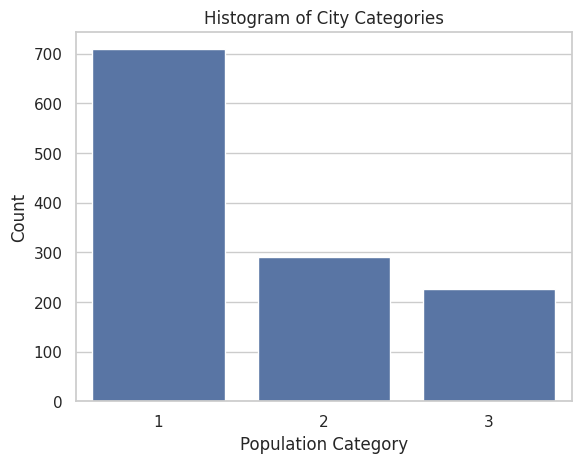

In [110]:
import seaborn as sns
sns.countplot(x='population_category', data=df)
plt.xlabel('Population Category')
plt.ylabel('Count')
plt.title('Histogram of City Categories')
plt.show()
# small     709
# big       291
# medium    226

# Save df for the job recommender (additional study)

In [111]:
df.to_csv('/content/drive/MyDrive/UNIPI AIDE/1° anno/Data mining & ML/Project/Data/resume_cleaned.csv', index = False)   #next transformed features not needed

# Resume similarity (additional study)

In [112]:
# Use df before train test splitting
df_similarity = df.reset_index().rename(columns = {'index': 'userID'})

I use 'category', 'experience', 'position', 'city', 'country', 'skills'. I convert text into its numeric representation using CountVectorizer or TfidfVectorizer. I build a df where each row is a resume vector of the score similarity (0-1) of it compared to each other resume

In [113]:
# Specify the names of the columns you want to merge
columns_to_merge = ['category', 'experience', 'position', 'city', 'country', 'skills']

df_similarity['data'] = df_similarity[columns_to_merge].apply(lambda x: ' '.join(x.astype(str)), axis=1)

In [114]:
def calculate_similarity(df):
    # Using TfidfVectorizer
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_vectorized = tfidf_vectorizer.fit_transform(df_similarity['data'])
    tfidf_similarities = cosine_similarity(tfidf_vectorized)
    # Build a resume-resume df
    df_tfidf_resume = pd.DataFrame(tfidf_similarities, columns=df_similarity['userID'], index=df_similarity['userID']).reindex()

    # Using CountVectorizer
    count_vectorizer = CountVectorizer()
    count_vectorized = count_vectorizer.fit_transform(df_similarity['data'])
    count_similarities = cosine_similarity(count_vectorized)
    # Build a resume-resume df
    df_count_resume = pd.DataFrame(count_similarities, columns=df_similarity['userID'], index=df_similarity['userID']).reindex()

    return df_tfidf_resume, df_count_resume

def extract_recommendations(df_tfidf_resume, df_count_resume, input_resume):
    # Extracting recommendations using TF-IDF
    tfidf_recommendations = pd.DataFrame(df_tfidf_resume.nlargest(11, input_resume)).iloc[1:].index

    # Extracting recommendations using CountVectorizer
    count_recommendations = pd.DataFrame(df_count_resume.nlargest(11, input_resume)).iloc[1:].index

    return tfidf_recommendations, count_recommendations

In [115]:
# Calculate similariy
df_tfidf_resume, df_count_resume = calculate_similarity(df_similarity)

In [116]:
# Extract recommendations (change input_resume)
tfidf_recommendations, count_recommendations = extract_recommendations(df_tfidf_resume, df_count_resume, input_resume=1)

print("TF-IDF Recommendations:")
print(tfidf_recommendations)
print("\nCountVectorizer Recommendations:")
print(count_recommendations)

TF-IDF Recommendations:
Index([32, 15, 34, 20, 10, 18, 28, 0, 8, 118], dtype='int64', name='userID')

CountVectorizer Recommendations:
Index([32, 15, 20, 8, 0, 18, 34, 37, 2, 10], dtype='int64', name='userID')


# Sentiment score for experience, position, skills

The scores are based on pre-trained models. So calculate a sentiment score on all the dataset (also testing data) do NOT affect the training I will do lately.
I am just getting new numerical features from categorical ones that I will erase for performing the training.
I do it before any text cleaning(stopword removal) because it affects the score.

The pre-trained models used to perform the sentiment scores came from Hugging Face:
> https://huggingface.co/serbog/xlm-roberta-job-skill-reranker

> https://huggingface.co/joblift-julian/skills_description_julian

I use 2 models because I saw they manage differently cases such as an empty value for a position. Using 2 models I got 2 scores and I can use both of them as features for the classification model.

In [23]:
def compute_scores(df, column_name, model_name):

    # Keep track of the number of times a column has been processed
    column_count = df.columns.str.startswith(f'{column_name}_scores_').sum() + 1

    # Convert the specified column to a list of strings
    data = list(df[column_name].astype(str))

    # Using pipeline class to make predictions from models available in the Hub in an easy way
    # Using the specified model for sentiment analysis
    model = pipeline(model=model_name)
    scores = model(data)

    # Extract skill scores from the model predictions
    scores = [item['score'] for item in scores]

    # Add the skill scores as a new column in the DataFrame
    df[f'{column_name}_scores_{column_count}'] = scores
    df

In [24]:
compute_scores(df, 'skills', "serbog/xlm-roberta-job-skill-reranker")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/835 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

In [25]:
compute_scores(df, 'skills', "joblift-julian/skills_description_julian")

config.json:   0%|          | 0.00/865 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/381 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [26]:
compute_scores(df, 'position', "serbog/xlm-roberta-job-skill-reranker")

In [27]:
compute_scores(df, 'position', "joblift-julian/skills_description_julian")

In [28]:
compute_scores(df, 'experience', "serbog/xlm-roberta-job-skill-reranker")

In [29]:
compute_scores(df, 'experience', "joblift-julian/skills_description_julian")

# EDA

## EDA - 'category' label

<ipython-input-117-89713ffe9f70>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_counts.values, y=category_counts.index, palette = palette)


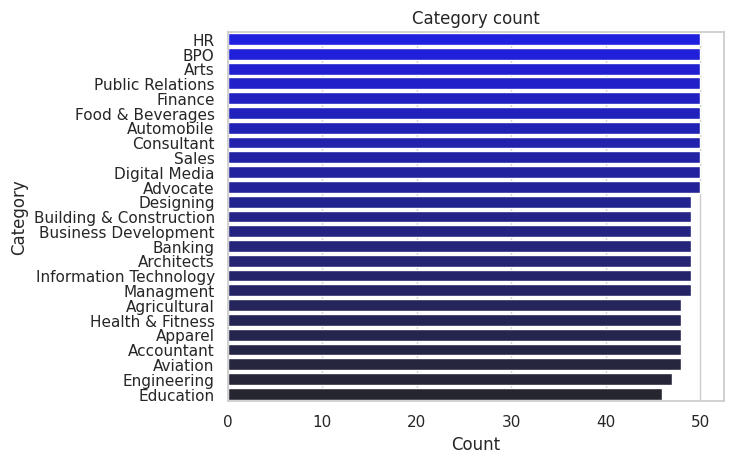

In [117]:
# Get the counts of each category (category will be the classification label!)
category_counts = df['category'].value_counts()

# Use a sequential color palette
palette = sns.color_palette("dark:blue_r", n_colors=len(category_counts))

# Plot the histogram using seaborn
sns.barplot(x=category_counts.values, y=category_counts.index, palette = palette)

# Labels
plt.xlabel('Count')
plt.ylabel('Category')
plt.title('Category count')

# Save plot
#plt.savefig('Category count.jpg')
plt.show()

## EDA - 'experience' and 'position' columns

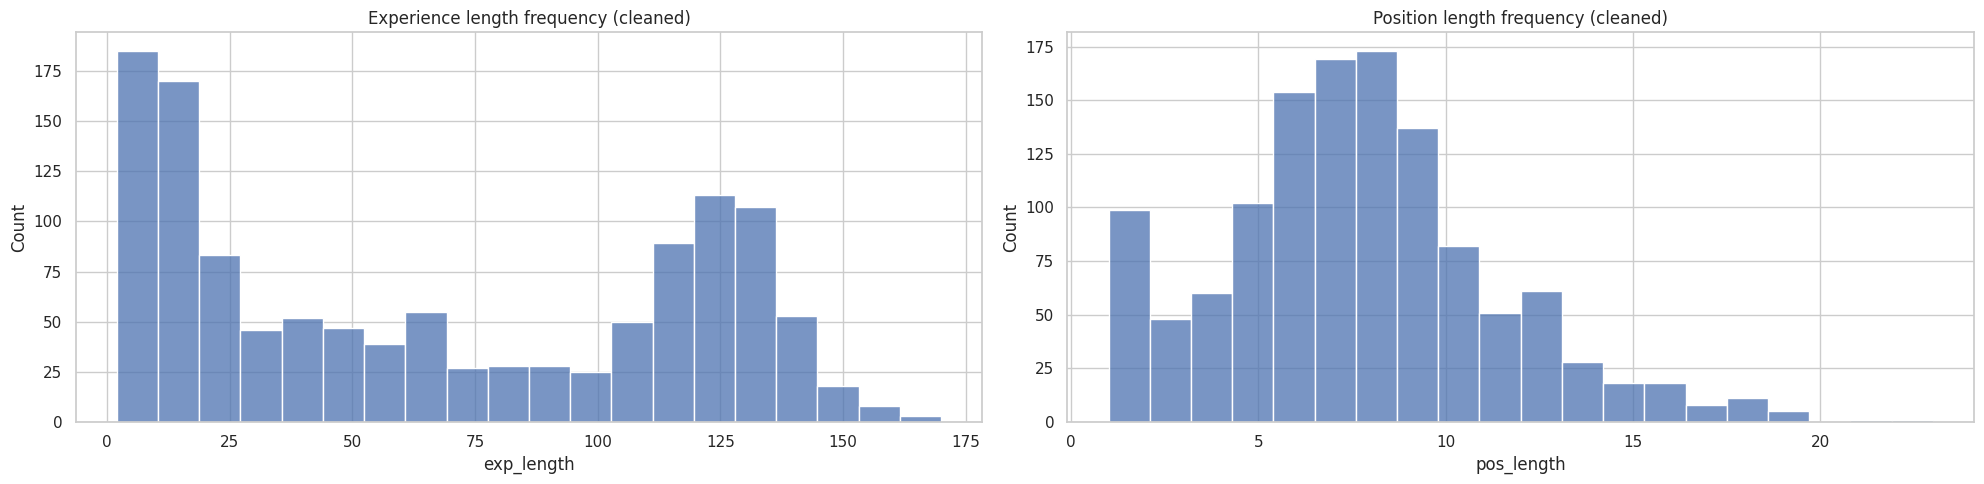

In [118]:
# Plot length frequency histograms for description, experience and position column. (after cleaning)
# Just don't do the preprocessing step to get the attribute columns before the cleaning
# Set the style to whitegrid (optional)
sns.set(style="whitegrid")

# Create a figure with three subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

# Plot the histogram for 'exp_length'
sns.histplot(df['exp_length'], bins=20, kde=False, ax=axes[0])
axes[0].set_title('Experience length frequency (cleaned)')

# Plot the histogram for 'pos_length'
sns.histplot(df['pos_length'], bins=20, kde=False, ax=axes[1])
axes[1].set_title('Position length frequency (cleaned)')

# Adjust layout
plt.tight_layout()

# Save the plots together
#plt.savefig('length_freq__cleaned_histograms.jpg')

# Show the plots
plt.show()

In [119]:
df['exp_length'].mean()

66.78874388254486

In [120]:
df['pos_length'].mean()

7.606035889070147

In [121]:
df['pos_length'].value_counts()

pos_length
8     173
7     169
6     154
9     137
5     102
10     82
4      60
1      52
11     51
3      48
2      47
12     36
14     28
13     25
16     18
15     18
18     11
17      8
19      5
23      1
21      1
Name: count, dtype: int64

  ## EDA - "location" column (city, country)

Perform some tests to confirm the intuition that in location column sometimes there's only the city, or the country or both.
For the model I need to improve this aspect by dividing it in 2 different columns: city and country.

In [122]:
t1 = df.location.str.contains('London', case=False, na=False).value_counts()    # try with other cities, even some letters
t2 = df.location.str.contains('United').value_counts()
t3 = df.location.str.contains('United Kingdom').value_counts()
print('---Test 1: location containing <London> ---\n', t1)
print('---Test 2: location containing <United> ---\n', t2)
print('---Test 3: location containing <United Kingdom> ---\n', t3)

---Test 1: location containing <London> ---
 location
False    1208
True       18
Name: count, dtype: int64
---Test 2: location containing <United> ---
 location
False    1173
True       53
Name: count, dtype: int64
---Test 3: location containing <United Kingdom> ---
 location
False    1182
True       44
Name: count, dtype: int64


In [123]:
# Get the counts where the condition is true
t1_counts = df.loc[df['location'].str.contains('London', case=False, na=False), 'location'].value_counts()

# Print each unique value and its count
for location, count in t1_counts.items():
    print(f"{location}: {count}")

London, United Kingdom: 9
London, Greater London, United Kingdom: 8
London, Canada: 1


In [124]:
# Let's see which are the most common locations
count_locations = df['location'].value_counts()
unique = df['location'].nunique()
print('---Frequency of each location: ---\n\n', count_locations, '\n\n ---How many unique locations there are? ---\n ', unique)

---Frequency of each location: ---

 location
Mumbai, Maharashtra, India        110
Bengaluru, Karnataka, India        74
India                              49
Pune, Maharashtra, India           44
New Delhi, Delhi, India            33
                                 ... 
Dharmapuri , India                  1
West Tripura, Tripura, India        1
Vishakhapatnam , India              1
Kanpur , India                      1
Krishnagiri, Tamil Nadu, India      1
Name: count, Length: 358, dtype: int64 

 ---How many unique locations there are? ---
  358


<ipython-input-125-fdae02e9b518>:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
/usr/local/lib/python3.10/dist-packages/geopandas/plotting.py:658: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


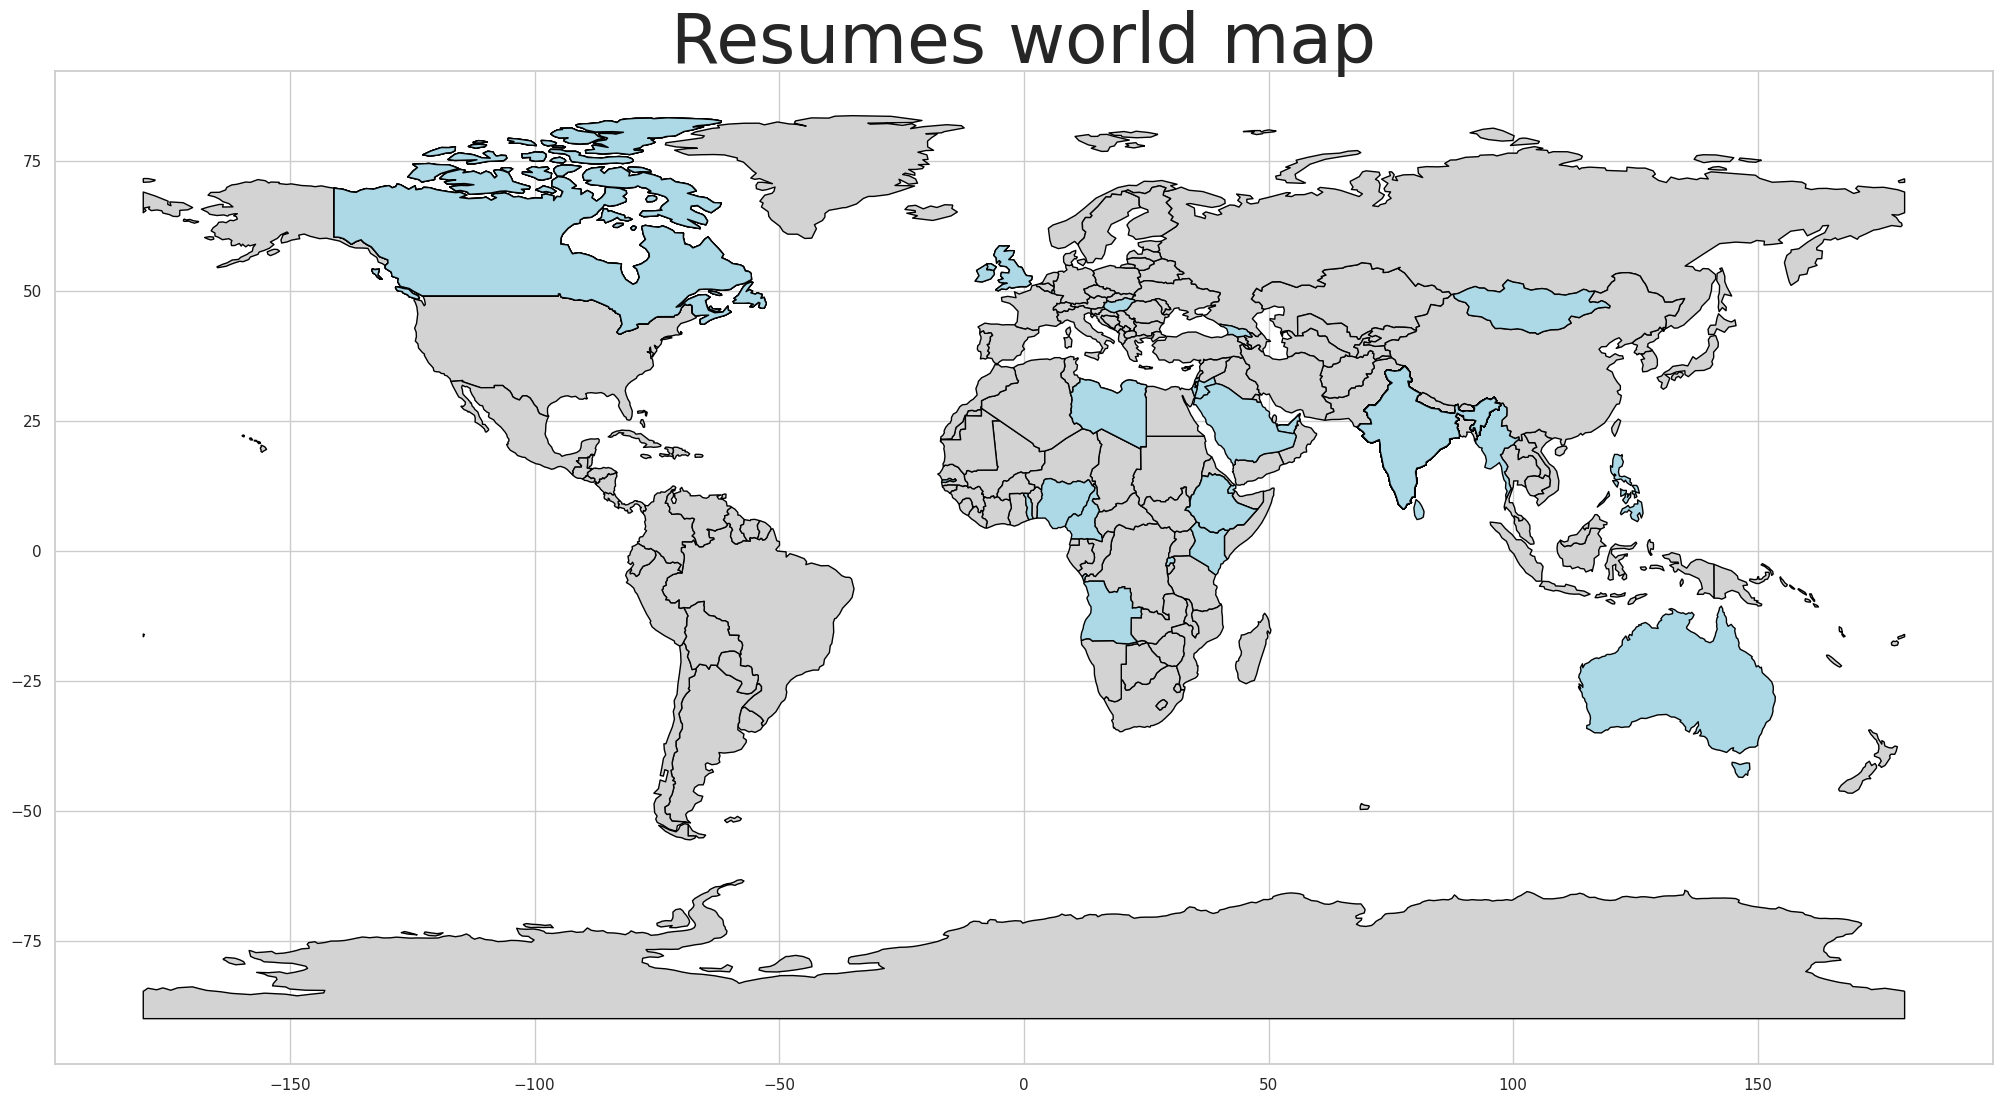

In [125]:
# Load the world map shapefile
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Merge the world map with the DataFrame based on the 'location' column
merged = world.merge(df, left_on='name', right_on='location', how='left')

# Plot the world map
ax = merged.plot(column='location', cmap='BuGn', figsize=(25, 15), legend=False)

# Plot countries without a specified position in light grey
merged[merged['location'].isnull()].plot(ax=ax, color='lightgrey', edgecolor='black')

# Plot countries with a specified position using a colormap
merged[merged['location'].notnull()].plot(ax=ax, column='location', color = 'lightblue', legend=False, edgecolor='black')

# Customize plot appearance
ax.set_title('Resumes world map', fontsize= 50)

# # Increase the size of the legend
# leg = ax.get_legend()
# leg.set_bbox_to_anchor((0.15, 0.8))  # Adjust the position of the legend
# for text in leg.get_texts():
#     text.set_fontsize('large')  # Set the font size of the legend items


# # Add markers for cities found in the 'location' column
# found_cities = df.dropna(subset=['location'])
# for idx, row in found_cities.iterrows():
#     city = row['location']
#     geometry = merged[merged['name'] == city]['geometry'].iloc[0]
#     ax.plot(geometry.x, geometry.y, 'bo', markersize=10)

plt.show()

Unfortunately american countries should be grouped all as the general name 'United States of America' to be matched by the map dataset.

In [126]:
# Not all the locations are recognised in the world map above
len(df.location.unique())
# Clearly USA countries are not recognised

358

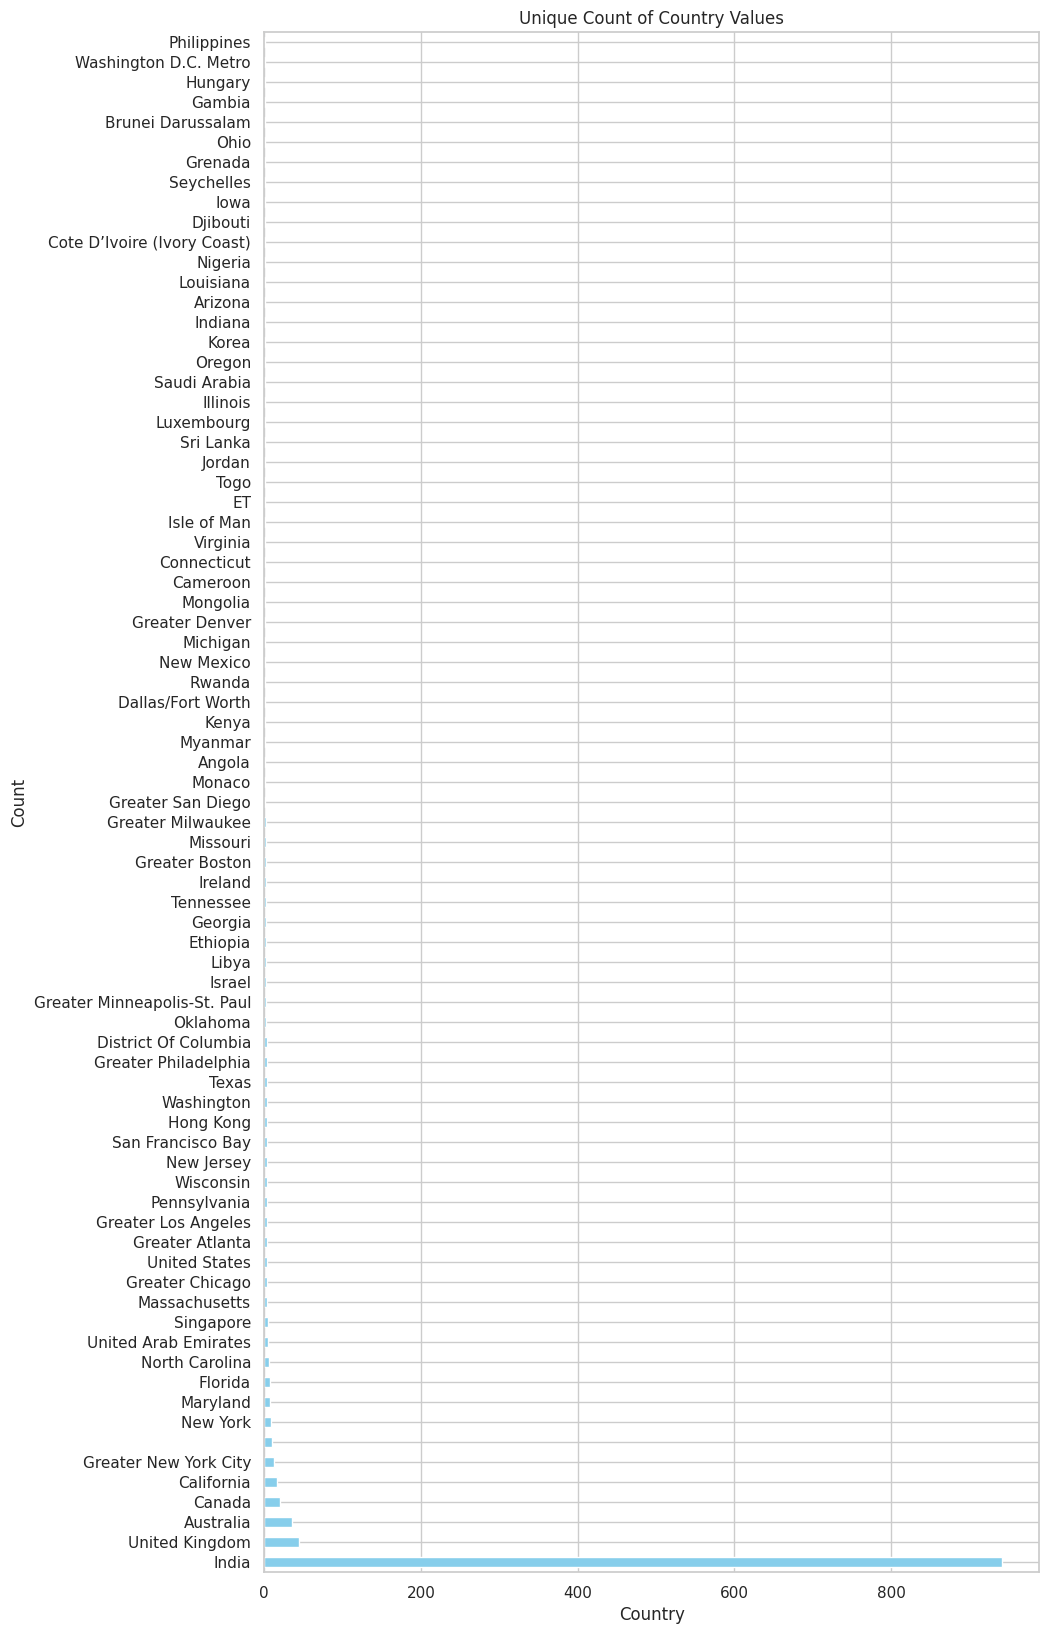

In [127]:
country_counts = df['country'].value_counts()

# Plotting the histogram
plt.figure(figsize=(10, 20))
country_counts.plot(kind='barh', color='skyblue')
plt.title('Unique Count of Country Values')
plt.xlabel('Country')
plt.ylabel('Count')
plt.show()

### USA matched in the map (experiment)

Most of the resumes are based in India. There are many also from different USA states that I want to categorize as USA for simplicity and clarity.
Same for african countries that I want to categorize simply as Africa.

In [128]:
# # Make a temporary df with the rows that are ok
# df1 = df[(df['country'] == 'India') | (df['country'] == 'United Kingdom') | (df['country'] == 'Australia') | (df['country'] == 'Canada') | (df['country'] == 'Israel') |
#           (df['country'] == 'Djibouti') | (df['country'] == 'Ethiopia') | (df['country'] == 'Gambia') | (df['country'] == 'Ireland') | (df['country'] == 'Kenya') |
#          (df['country'] == 'Nigeria') | (df['country'] == 'Rwanda') | (df['country'] == 'Sri Lanka') | (df['country'] == 'United Arab Emirates')]

# # make a temporary df with rows that need to be still processed
# conditions = (df['country'] != 'India') & (df['country'] != 'United Kingdom') & (df['country'] != 'Australia') & (df['country'] != 'Canada') & (df['country'] != 'Israel') & (df['country'] != 'Djibouti') & (df['country'] != 'Ethiopia') & (df['country'] != 'Gambia') & (df['country'] != 'Ireland') & (df['country'] != 'Kenya') & (df['country'] != 'Nigeria') & (df['country'] != 'Rwanda') & (df['country'] != 'Sri Lanka') & (df['country'] != 'United Arab Emirates')
# df2 = df[conditions]



In [129]:
# # Concatenate 'city' and 'country' columns with a comma and space, but only if 'country' is not None
# df2.loc[:, 'city'] = df.apply(lambda row: f"{row['city']}, {row['country']}" if row['country'] is not None else row['city'], axis=1)

# # Rename these countries all as USA
# df2['country'] = 'United States of America'

In [130]:
# # Do the same with african countries
# african_countries = (df['country'] == 'Djibouti') | (df['country'] == 'Ethiopia') | (df['country'] == 'Gambia') | (df['country'] == 'Kenya') | (df['country'] == 'Nigeria') | (df['country'] == 'Rwanda') | (df['country'] == 'Sri Lanka')
# df3 = df[african_countries]

# # Rename these countries all as Africa
# df3['country'] = 'Africa'

In [131]:
# # Now I can concatenate the 3 dataframes
# df = pd.concat([df1, df2, df3], axis=0, ignore_index=True)

# # drop rows where country is still a small african state (because of df1)
# # Specify the words to be dropped
# words_to_drop = ['Djibouti', 'Ethiopia', 'Gambia', 'Kenya', 'Nigeria', 'Rwanda', 'Sri Lanka']
# # Drop rows where 'country' column contains specific words
# df = df[~df['country'].isin(words_to_drop)]

In [132]:
# print('----- Check how many city cells are empty: ----- \n', df.city.isnull().value_counts())   # None of them are empty
# print('----- Check how many country cells are empty: ----- \n', df.country.isnull().value_counts())

In [133]:
# # group by country
# plt.figure(figsize=(5, 5))
# ax = df.groupby('country').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
# ax.spines[['top', 'right',]].set_visible(False)

# plt.title('Group by country')
# # Set x-axis label font size
# ax.tick_params(axis='y', labelsize=10)

In [134]:
# # Load the world map shapefile
# world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# # Merge the world map with the DataFrame based on the 'location' column
# merged = world.merge(df, left_on='name', right_on='country', how='left')

# # Plot the world map
# ax = merged.plot(column='country', cmap='BuGn', figsize=(15, 15), legend=False)

# # Plot countries without a specified position in light grey
# merged[merged['country'].isnull()].plot(ax=ax, color='lightgrey', edgecolor='black')

# # Plot countries with a specified position using a colormap
# merged[merged['country'].notnull()].plot(ax=ax, column='country', cmap='viridis', legend=True, edgecolor='black')

# # Customize plot appearance
# ax.set_title('Resumes world map')

# plt.show()
# # I added USA in the map But now I can't see African countries

# Save&Load cleaned df

Save and then load the df, allows to easily jump to the model implementation, without waiting some minutes for the sentiment score steps.

In [6]:
# save final df to reload and reuse it
# df.to_csv('/content/drive/MyDrive/UNIPI AIDE/1° anno/Data mining & ML/Project/Data/resume_final.csv', index=False)

In [7]:
df = pd.read_csv('/content/drive/MyDrive/UNIPI AIDE/1° anno/Data mining & ML/Project/Data/resume_final.csv')
df = df.fillna('')    # when reloading the df, the empty values became NaN

In [8]:
df

,category,experience,position,location,skills,exp_length,pos_length,city,country,region,population,population_category,skills_scores_1,skills_scores_2,position_scores_1,position_scores_2,experience_scores_1,experience_scores_2
0,HR,Senior Vice President & Head of HRCompany Name...,Senior Vice President and Head of HR- Samsung ...,"Gurgaon, Haryana, India","Performance Management, Human Resources, Talen...",140,11,Gurgaon,India,Haryana,197340,2,0.731018,0.492856,0.796132,0.497304,0.801988,0.453053
1,HR,Head of Talent Acquisition - India & APAC and ...,Head Talent Acquisition and HR Leader for Heal...,"Pune, Maharashtra, India","Talent Acquisition, Employee Engagement, Vendo...",133,10,Pune,India,Maharashtra,3124458,2,0.695803,0.490798,0.806156,0.494926,0.775287,0.486893
2,HR,Company NameIBM INDIA Pvt LtdTotal Duration8 y...,HR@IBM,"Bengaluru, Karnataka, India","Human Resources, Recruiting, Team Management, ...",123,1,Bengaluru,India,Karnataka,8443675,3,0.656888,0.494251,0.150206,0.501573,0.806442,0.448657
3,HR,HR/Admin/Personnel/LegalCompany NameHR and HR ...,HR,"Pune , India",,16,1,,India,Pune,1,1,0.840311,0.506048,0.781801,0.508631,0.749157,0.484002
4,HR,Company NameEXLTotal Duration6 yrs 4 mosTitleV...,Vice President - Digital HR Transformation Lea...,"Delhi, Delhi, India","Team Management, Human Resources, Employee Eng...",129,16,Delhi,India,Delhi,10927986,3,0.726910,0.492085,0.770022,0.495564,0.793294,0.455060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1221,Aviation,airline and aviation industryCompany Nameairli...,airline and aviation industry at airline company,"Chandigarh, Chandigarh, India",,6,7,Chandigarh,India,Chandigarh,1,1,0.840311,0.506048,0.318422,0.492569,0.308452,0.475907
1222,Aviation,Production ManagerCompany NameTANEJA AEROSPACE...,Production Manager at TANEJA AEROSPACE AND AVI...,"Krishnagiri, Tamil Nadu, India",,12,8,Krishnagiri,India,Tamil Nadu,66419,1,0.840311,0.506048,0.813629,0.500557,0.662077,0.481754
1223,Aviation,Human Resources ExecutiveCompany NameGoAirDate...,HR Executive at GoAir | MBA Graduate\n Spec...,"Mumbai, Maharashtra, India","Management, Goal Seek, Customer Service",67,11,Mumbai,India,Maharashtra,12691836,3,0.652983,0.498734,0.838652,0.497694,0.528299,0.453528
1224,Aviation,Institute of Logistics and Aviation management...,Student at Institute of Logistics and Aviation...,"Mumbai, Maharashtra, India","Tally ERP, Workshops",24,8,Mumbai,India,Maharashtra,12691836,3,0.422110,0.486915,0.350713,0.487515,0.820780,0.480844


# Transform 'category' as a binary label

In [9]:
df['category'].unique()

array(['HR', 'Designing', 'Managment', 'Information Technology',
       'Education', 'Advocate', 'Business Development',
       'Health & Fitness', 'Agricultural', 'BPO', 'Sales', 'Consultant',
       'Digital Media', 'Building & Construction', 'Automobile',
       'Banking', 'Engineering', 'Food & Beverages', 'Finance', 'Apparel',
       'Accountant', 'Architects', 'Public Relations', 'Arts', 'Aviation'],
      dtype=object)

In [10]:
# List of categories to keep as stem
stem = ['Managment', 'Information Technology', 'Business Development', 'BPO', 'Sales', 'Consultant', 'Banking',
       'Engineering', 'Automobile', 'Finance',  'Accountant', 'Architects', 'Aviation']

# Replace valid categories with 'stem' and others with 'other'
df['category'] = df['category'].apply(lambda x: 1 if x in stem else 0)

In [11]:
# # Separate label from features
X = df.drop('category', axis =1)
y = df['category']

# Model functions

Here are listed the functions used for each k-fold inside the pipeline:
- Transform skills column
- Wordcloud on 'skills'
- Word embedding on 'skills'
- Word embedding on 'experience'
- Normalize data and drop some columns.


## Transform skills column

In [12]:
def transform_skills(X):
    print('START transform_skills')

    # Split the 'skills' column by commas and create new columns
    df_skills = X['skills'].str.split(',', expand=True)

    # Apply the str.strip() method to remove leading and trailing whitespaces
    df_skills = df_skills.apply(lambda x: x.str.strip())

    # Create a list of unique skills
    skill_list = df_skills.values.flatten()

    # Filter out empty values
    skill_list = [skill for skill in skill_list if skill]

    #print("The length of the skill list is: ", len(skill_list))
    #print(skill_list)

    # Print a list of unique skills (skill appear only once)
    unique_skill_list = list(set(skill_list))
    #print("\nThe length of the UNIQUE skill list is: ", len(unique_skill_list))
    #print(unique_skill_list)

    # Sort the list in alphabetical order
    sorted_list = sorted(skill_list)
    #print(sorted_list)

    # Sort the UNIQUE list in alphabetical order
    unique_sorted_list = sorted(unique_skill_list)
    #print(unique_sorted_list)

    # Count occurrences of each skill
    skill_counts = Counter(skill_list)
    # Print the skill counts
    # for skill, count in skill_counts.items():
    #   print(f"{skill}: {count}")

    # Filter skill counts for skills with more than 30 occurrences
    filtered_skill_counts = {skill: count for skill, count in skill_counts.items() if count > 30}

    # Extract filtered skills and counts
    filtered_skills = list(filtered_skill_counts.keys())
    filtered_counts = list(filtered_skill_counts.values())

    # Plot histogram
    plt.figure(figsize=(10, 6))
    plt.bar(filtered_skills, filtered_counts, color='skyblue')
    plt.xlabel('Skills')
    plt.ylabel('Occurrences')
    plt.title('Occurrences of Skills (More than 30 occurrences)')
    plt.xticks(rotation=45, ha='right')  # Rotate x labels for better readability
    plt.tight_layout()
    plt.show()

    # Define a function to map occurrences to categories
    def map_popularity(occurrences):
        if occurrences is None:
          return "<UNK>"
        elif 1 <= occurrences <= 10:
            return 'rare'
        elif 11 < occurrences <= 30:
            return 'common'
        elif occurrences > 30 or occurrences == 0:
            return 'popular'

    # Define a dictionary mapping for category weights
    category_weights = {
        '<UNK>': 1,
        'rare': 3,
        'common': 2,
        'popular': 1
    }


    #Map occurrences to categories for each skill and sum the weighted counts
    skill_popularity = X['skills'].apply(lambda x: sum(
        category_weights.get(map_popularity(skill_counts.get(skill)), 0) if skill!= '' else 0
        for skill in x.split(',')
    ))
    X['skill_popularity'] = skill_popularity    #(X.append([skill_popularity])).to_frame()

    print('END transform_skills')

    return X

## Wordcloud on 'skills'

In [13]:
def wordcloud_skills(X):
    print('START wordcloud_skills')

    # function to remove some "junk" text
    def cleanText(text):
        text = re.sub('http\S+\s*', ' ', text)  # remove URLs
        #text = re.sub('RT|cc', ' ', text)  # remove RT and cc
        text = re.sub('#\S+', '', text)  # remove hashtags
        text = re.sub('@\S+', '  ', text)  # remove mentions
        text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), ' ', text)  # remove punctuations
        text = re.sub(r'[^\x00-\x7f]',r'', text)     # remove each non-ASCII character
        #text = re.sub('\s+', ' ', text)  # remove extra whitespace
        #text = re.sub('see more', '', text) # remove "see more" present at the end of each description
        return text

    # function to remove english stopwords
    def removeStopwords(text):
        stop_words = set(stopwords.words('english'))
        words = nltk.word_tokenize(text)
        filtered_words = [word for word in words if word.lower() not in stop_words]
        return ' '.join(filtered_words)

    # Apply functions
    X['skills'] = X['skills'].apply(lambda x: cleanText(x)).apply(lambda x: removeStopwords(x))


    # Concatenate all text data from the specified column into a single string
    text_data = ' '.join(X['skills'])
    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(text_data)

    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

    print('END wordcloud_skills')

    return X

## Word embeddings on 'skills'

Word2Vec, Doc2Vec and BERT for the ‘skills’ feature. Average pooling to obtain a unit vector suitable for the classification.


In [14]:
def word_embeddings_skills(X):
    print('START word_embeddings_skills')

    # Tokenize the text

    # Make word embeddings using STEM skills
    # Temporarily put back together X and y
    df = pd.concat([X, y], axis=1)

    # Filter X based on the condition X['category'] == 1
    df_stem = df[df['category'] == 1]

    # Split the skills column
    tokenized_corpus = df_stem['skills'].str.split(',', expand=True)

    # tokenized_corpus = [[word.lower() for word in word_tokenize(text) if word in skill_list] for text in X['skills']]

    # Apply the str.strip() method to remove leading and trailing whitespaces
    tokenized_corpus = tokenized_corpus.apply(lambda x: x.str.strip())

    # Create a list of unique skills
    tokenized_corpus = tokenized_corpus.values.flatten()

    # Filter out empty values
    tokenized_corpus = [skill for skill in tokenized_corpus if skill]

    # Print a list of unique skills (skill appear only once)
    tokenized_corpus = list(set(tokenized_corpus))
    tokenized_corpus = [str(item) for item in tokenized_corpus]


    tokenized_corpus = [word_tokenize(text.lower()) for text in tokenized_corpus]

    # Train Word2Vec model
    model = Word2Vec(sentences=tokenized_corpus, vector_size=100, window=5, min_count=1, workers=4)

    # Get word embeddings
    word_embeddings = model.wv

    # Now I average the word embeddings of each sentence to represent it
    def sentence_embedding(sentence):
        tokens = word_tokenize(sentence.lower())
        embeddings = [word_embeddings[word] for word in tokens if word in word_embeddings]
        if embeddings:
            return sum(embeddings) / len(embeddings)
        else:
            return [0] * 100  # If no embeddings found, return zeros vector of the same size

    # Add a new column to the DataFrame with the sentence embeddings
    X['word2vec_embedding'] = X['skills'].apply(sentence_embedding)


    # Doc2Vec
    # Tokenize the text and create TaggedDocuments
    tokenized_corpus = [str(text) for text in list(set(df_stem['skills']))]

    tagged_data = [TaggedDocument(words=word_tokenize(text.lower()), tags=[str(text)]) for text in tokenized_corpus]

    # Train Doc2Vec model
    doc2vec_model = Doc2Vec(vector_size=100, window=5, min_count=1, workers=4, epochs=20)
    doc2vec_model.build_vocab(tagged_data)
    doc2vec_model.train(tagged_data, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)

    # Get document embeddings
    document_embeddings = [doc2vec_model.infer_vector(word_tokenize(text.lower())) for text in [str(text) for text in list(X['skills'])]]

    # Add document embeddings to DataFrame
    X['doc2vec_embedding'] = document_embeddings

    # BERT
    # Load pre-trained BERT model and tokenizer
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertModel.from_pretrained('bert-base-uncased')

    # Tokenize and encode text
    encoded_inputs = tokenizer(X['skills'].tolist(), padding=True, truncation=True, return_tensors='pt')

    # Pass the inputs through the model to obtain hidden states
    with torch.no_grad():
        outputs = model(**encoded_inputs)

    # Obtain document embeddings by averaging token embeddings
    token_embeddings = outputs.last_hidden_state  # Last layer hidden states
    document_embeddings = torch.mean(token_embeddings, dim=1)  # Average token embeddings along the sequence length dimension

    # Add document embeddings to DataFrame
    X['bert_embedding'] = document_embeddings.tolist()

    print('END word_embeddings_skills')

    return X

## Word embeddings on 'experience'

In [15]:
def word_embeddings_exp(X):
    print('START word_embeddings_exp')

    # Tokenize the text

    # Make word embeddings using STEM skills
    # Temporarily put back together X and y
    df = pd.concat([X, y], axis=1)

    # Filter X based on the condition X['category'] == 1
    df_stem = df[df['category'] == 1]

    # Split the skills column
    tokenized_corpus = df_stem['experience'].str.split('–', expand=True)

    # tokenized_corpus = [[word.lower() for word in word_tokenize(text) if word in skill_list] for text in X['skills']]

    # Apply the str.strip() method to remove leading and trailing whitespaces
    tokenized_corpus = tokenized_corpus.apply(lambda x: x.str.strip())

    # Create a list of unique skills
    tokenized_corpus = tokenized_corpus.values.flatten()

    # Filter out empty values
    tokenized_corpus = [skill for skill in tokenized_corpus if skill]

    # Print a list of unique skills (skill appear only once)
    tokenized_corpus = list(set(tokenized_corpus))
    tokenized_corpus = [str(item) for item in tokenized_corpus]


    tokenized_corpus = [word_tokenize(text.lower()) for text in tokenized_corpus]

    # Train Word2Vec model
    model = Word2Vec(sentences=tokenized_corpus, vector_size=100, window=5, min_count=1, workers=4)

    # Get word embeddings
    word_embeddings = model.wv

    # Now I average the word embeddings of each sentence to represent it
    def sentence_embedding(sentence):
        tokens = word_tokenize(sentence.lower())
        embeddings = [word_embeddings[word] for word in tokens if word in word_embeddings]
        if embeddings:
            return sum(embeddings) / len(embeddings)
        else:
            return [0] * 100  # If no embeddings found, return zeros vector of the same size

    # Add a new column to the DataFrame with the sentence embeddings
    X['word2vec_embedding_exp'] = X['experience'].apply(sentence_embedding)


    # Doc2Vec
    # Tokenize the text and create TaggedDocuments
    tokenized_corpus = [str(text) for text in list(set(df_stem['experience']))]

    tagged_data = [TaggedDocument(words=word_tokenize(text.lower()), tags=[str(text)]) for text in tokenized_corpus]

    # Train Doc2Vec model
    doc2vec_model = Doc2Vec(vector_size=100, window=5, min_count=1, workers=4, epochs=20)
    doc2vec_model.build_vocab(tagged_data)
    doc2vec_model.train(tagged_data, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)

    # Get document embeddings
    document_embeddings = [doc2vec_model.infer_vector(word_tokenize(text.lower())) for text in [str(text) for text in list(X['skills'])]]

    # Add document embeddings to DataFrame
    X['doc2vec_embedding_exp'] = document_embeddings

    # BERT (Commented because there's not enough ram available on Colab)
    # # Load pre-trained BERT model and tokenizer
    # tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    # model = BertModel.from_pretrained('bert-base-uncased')

    # # Tokenize and encode text
    # encoded_inputs = tokenizer(X['experience'].tolist(), padding=True, truncation=True, return_tensors='pt')

    # # Pass the inputs through the model to obtain hidden states
    # with torch.no_grad():
    #     outputs = model(**encoded_inputs)

    # # Obtain document embeddings by averaging token embeddings
    # token_embeddings = outputs.last_hidden_state  # Last layer hidden states
    # document_embeddings = torch.mean(token_embeddings, dim=1)  # Average token embeddings along the sequence length dimension

    # # Add document embeddings to DataFrame
    # X['bert_embedding_exp'] = document_embeddings.tolist()

    print('END word_embeddings_exp')

    return X

## Normalize and drop columns

Note: To change configurations [basic, +3we, +5we] uncomment the corresponding average pooling here and inside the general pipeline.

In [25]:
def normalize_dropcols(X):
    print('START normalize_dropcols')

    ######
    def average_pooling(embeddings):
        return np.mean(embeddings, axis=0)

    # Apply average pooling to obtain fixed-length vectors (just do the average)
    # X['word2vec_embedding'] = X['word2vec_embedding'].apply(average_pooling)            # +3we
    # X['doc2vec_embedding'] = X['doc2vec_embedding'].apply(average_pooling)              # +3we
    # X['bert_embedding'] = X['bert_embedding'].apply(average_pooling)                    # +3we
    # X['word2vec_embedding_exp'] = X['word2vec_embedding_exp'].apply(average_pooling)    # +5we
    # X['doc2vec_embedding_exp'] = X['doc2vec_embedding_exp'].apply(average_pooling)      # +5we
    # X['bert_embedding_exp'] = X['bert_embedding_exp'].apply(average_pooling)            # +5we <-leave commented, not enough memory on colab
    ####

    # Drop useless columns for the model
    X = X.drop(columns = ['experience', 'position', 'location', 'skills', 'city', 'country', 'region', 'population'])
    # Min-Max Normalization
    min_max_scaler = MinMaxScaler()
    X = pd.DataFrame(min_max_scaler.fit_transform(X), columns=X.columns)

    print('END normalize_dropcols')

    return X

# Pipelines

Create the skf object and save it on Drive. Then load it to reuse with different pipeline configurations (with and without wordembeddings). Do it once.

In [17]:
# # Stratfied k-fold cross validation
# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# # Save the skf object to a file
# dump(skf, 'skf.joblib')

# import shutil
# # Copy skf.joblib to Google Drive
# shutil.copy('skf.joblib', '/content/drive/MyDrive/UNIPI AIDE/1° anno/Data mining & ML/Project/Data/')

In [18]:
# Load the skf object from the file
skf = load('/content/drive/MyDrive/UNIPI AIDE/1° anno/Data mining & ML/Project/Data/skf.joblib')

In [19]:
# # Check how folds are built
#
# # Iterate over the splits and print the indices of train and test sets for each fold
# for fold, (train_index, test_index) in enumerate(skf.split(X, y), 1):
#     print(f"Fold {fold}:")
#     print("Train Indices:", train_index)
#     print("Test Indices:", test_index)
#     print()

Build the general pipeline, then add the classifier separately using the custom function.
If reusing the pipeline, is needed to pop out the previous classifier before adding the new one. Can print the pipeline to visualize what's inside.

In [24]:
# Build the pipeline (comment word embeddings as needed)
pipeline = Pipeline([
    ('transform_skills', FunctionTransformer(transform_skills)),
    ('wordcloud_skills', FunctionTransformer(wordcloud_skills)),
    # ('word_embeddings_skills', FunctionTransformer(word_embeddings_skills)),    # +3we
    # ('word_embeddings_exp', FunctionTransformer(word_embeddings_exp)),          # +5we
    ('normalize_dropcols', FunctionTransformer(normalize_dropcols))
])

In [21]:
# Function to add classifier to the pipeline
def add_classifier_to_pipeline(pipeline, classifier):
    pipeline.steps.append(('classifier', classifier))
    return pipeline

In [22]:
def get_averaged_metrics(scores, classifier_name):
    averaged_metrics = {
        'accuracy': scores['test_accuracy'].mean().round(2),
        'precision': scores['test_precision'].mean().round(2),
        'recall': scores['test_recall'].mean().round(2),
        'f1': scores['test_f1'].mean().round(2)
    }
    return f"Averaged Metrics for {classifier_name}:\n {averaged_metrics}"

# Evaluation

The general pipeline is already built. Just add the classificator before applying cross validation.

In [26]:
# Add Logistic Regression classifier and evaluate
pipeline_lr = add_classifier_to_pipeline(pipeline, LogisticRegression(max_iter=1000, solver='lbfgs'))
scores_lr = cross_validate(pipeline_lr, X, y, cv=skf, scoring=['accuracy', 'f1', 'precision', 'recall'], return_train_score=False, return_estimator=False)
print('\nLogistic Regression: \n', scores_lr)

Output hidden; open in https://colab.research.google.com to view.

In [27]:
pipeline.steps.pop()  # Remove the previous classifier step

# Add random forest classifier and evaluate
pipeline_rf = add_classifier_to_pipeline(pipeline, RandomForestClassifier())
scores_rf = cross_validate(pipeline_rf, X, y, cv=skf, scoring=['accuracy', 'f1', 'precision', 'recall'], return_train_score=False, return_estimator=False)
print('\nRandom Forest: \n', scores_rf)

Output hidden; open in https://colab.research.google.com to view.

In [215]:
pipeline.steps.pop()  # Remove the previous classifier step

# Add svc classifier and evaluate
pipeline_svc = add_classifier_to_pipeline(pipeline, SVC(kernel='linear'))
scores_svc = cross_validate(pipeline_svc, X, y, cv=skf, scoring=['accuracy', 'f1', 'precision', 'recall'], return_train_score=False, return_estimator=False)
print('\nSVC: \n', scores_svc)

Output hidden; open in https://colab.research.google.com to view.

In [216]:
pipeline.steps.pop()  # Remove the previous classifier step

# Add mnb classifier and evaluate
pipeline_mnb = add_classifier_to_pipeline(pipeline, MultinomialNB())
scores_mnb = cross_validate(pipeline_mnb, X, y, cv=skf, scoring=['accuracy', 'f1', 'precision', 'recall'], return_train_score=False, return_estimator=False)
print('\nMultinomialNB: \n', scores_mnb)

Output hidden; open in https://colab.research.google.com to view.

In [217]:
pipeline.steps.pop()  # Remove the previous classifier step

# Add xgboost classifier and evaluate
pipeline_xgb = add_classifier_to_pipeline(pipeline, XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
scores_xgb = cross_validate(pipeline_xgb, X, y, cv=skf, scoring=['accuracy', 'f1', 'precision', 'recall'], return_train_score=False, return_estimator=False)
print('\nXGBoost: \n', scores_xgb)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
print('\nLogistic Regression: \n', scores_lr)
print('\nRandom Forest: \n', scores_rf)
print('\nSVC: \n', scores_svc)
print('\nMultinomialNB: \n', scores_mnb)
print('\nXGBoost: \n', scores_xgb)

In [218]:
# Print averaged metrics - BASIC CONFIGURATION
averaged_metrics_lr = get_averaged_metrics(scores_lr, "Logistic Regression")
print(averaged_metrics_lr)

averaged_metrics_rf = get_averaged_metrics(scores_rf, "Random Forest")
print(averaged_metrics_rf)

averaged_metrics_svc = get_averaged_metrics(scores_svc, "SVC")
print(averaged_metrics_svc)

averaged_metrics_mnb = get_averaged_metrics(scores_mnb, "MultinomialNB")
print(averaged_metrics_mnb)

averaged_metrics_xgb = get_averaged_metrics(scores_xgb, "XGBoost")
print(averaged_metrics_xgb)

Averaged Metrics for Logistic Regression:
 {'accuracy': 0.6, 'precision': 0.62, 'recall': 0.63, 'f1': 0.62}
Averaged Metrics for Random Forest:
 {'accuracy': 0.6, 'precision': 0.62, 'recall': 0.59, 'f1': 0.6}
Averaged Metrics for SVC:
 {'accuracy': 0.61, 'precision': 0.62, 'recall': 0.68, 'f1': 0.64}
Averaged Metrics for MultinomialNB:
 {'accuracy': 0.56, 'precision': 0.55, 'recall': 0.85, 'f1': 0.67}
Averaged Metrics for XGBoost:
 {'accuracy': 0.59, 'precision': 0.61, 'recall': 0.57, 'f1': 0.59}


In [186]:
# # Print averaged metrics - +3WE CONFIGURATION
# averaged_metrics_lr = get_averaged_metrics(scores_lr, "Logistic Regression")
# print(averaged_metrics_lr)

# averaged_metrics_rf = get_averaged_metrics(scores_rf, "Random Forest")
# print(averaged_metrics_rf)

# averaged_metrics_svc = get_averaged_metrics(scores_svc, "SVC")
# print(averaged_metrics_svc)

# averaged_metrics_mnb = get_averaged_metrics(scores_mnb, "MultinomialNB")
# print(averaged_metrics_mnb)

# averaged_metrics_xgb = get_averaged_metrics(scores_xgb, "XGBoost")
# print(averaged_metrics_xgb)

Averaged Metrics for Logistic Regression:
 {'accuracy': 0.59, 'precision': 0.6, 'recall': 0.68, 'f1': 0.63}
Averaged Metrics for Random Forest:
 {'accuracy': 0.59, 'precision': 0.61, 'recall': 0.59, 'f1': 0.6}
Averaged Metrics for SVC:
 {'accuracy': 0.59, 'precision': 0.59, 'recall': 0.71, 'f1': 0.64}
Averaged Metrics for MultinomialNB:
 {'accuracy': 0.57, 'precision': 0.56, 'recall': 0.82, 'f1': 0.66}
Averaged Metrics for XGBoost:
 {'accuracy': 0.58, 'precision': 0.59, 'recall': 0.65, 'f1': 0.61}


In [207]:
# # Print averaged metrics - +5WE CONFIGURATION
# averaged_metrics_lr = get_averaged_metrics(scores_lr, "Logistic Regression")
# print(averaged_metrics_lr)

# averaged_metrics_rf = get_averaged_metrics(scores_rf, "Random Forest")
# print(averaged_metrics_rf)

# averaged_metrics_svc = get_averaged_metrics(scores_svc, "SVC")
# print(averaged_metrics_svc)

# averaged_metrics_mnb = get_averaged_metrics(scores_mnb, "MultinomialNB")
# print(averaged_metrics_mnb)

# averaged_metrics_xgb = get_averaged_metrics(scores_xgb, "XGBoost")
# print(averaged_metrics_xgb)

Averaged Metrics for Logistic Regression:
 {'accuracy': 0.66, 'precision': 0.68, 'recall': 0.68, 'f1': 0.67}
Averaged Metrics for Random Forest:
 {'accuracy': 0.67, 'precision': 0.72, 'recall': 0.61, 'f1': 0.63}
Averaged Metrics for SVC:
 {'accuracy': 0.66, 'precision': 0.68, 'recall': 0.71, 'f1': 0.68}
Averaged Metrics for MultinomialNB:
 {'accuracy': 0.58, 'precision': 0.57, 'recall': 0.8, 'f1': 0.66}
Averaged Metrics for XGBoost:
 {'accuracy': 0.67, 'precision': 0.7, 'recall': 0.66, 'f1': 0.67}


In [30]:
# Perform the t-test:
t_stat, p_value = stats.ttest_ind(scores_lr['test_accuracy'], scores_rf['test_accuracy'])    # [scores_lr, scores_rf, scores_svc, scores_mnb, scores_xgb]

# Interpret the results:
alpha = 0.05
if p_value < alpha:
           print("Reject the null hypothesis; there is a significant difference between the two distributions.")
else:
    print("Fail to reject the null hypothesis; there is no significant difference between the two distributions.")

Fail to reject the null hypothesis; there is no significant difference between the two distributions.


In [36]:
from scipy.stats import shapiro

differences = [a1 - a2 for a1, a2 in zip(scores_lr['test_accuracy'], scores_rf['test_accuracy'])]
stat, p = shapiro(differences)

# Interpretation
if p_value > 0.05:
    print("The differences are normally distributed (fail to reject the null hypothesis).")
else:
    print("The differences are not normally distributed (reject the null hypothesis).")

The differences are normally distributed (fail to reject the null hypothesis).
